# Optimization Tutorial

Trey V. Wenger (c) August 2024

Here we demonstrate how to optimize the number of cloud components in a `bayes_spec` model.

In [1]:
# General imports    
import os
import pickle

import matplotlib.pyplot as plt
import arviz as az
import pandas as pd
import numpy as np
import pymc as pm

import pymc
print("pymc version:", pymc.__version__)

import bayes_spec
print("bayes_spec version:", bayes_spec.__version__)

# Notebook configuration
pd.options.display.max_rows = None
    
# random state
rng = np.random.RandomState(seed=1234)

pymc version: 5.16.2
bayes_spec version: 1.5.0


## Model Definition and Simulated Data

Like in the basic tutorial for `GaussNoiseModel`, our model is a Gaussian line profile with the spectral noise as a free parameter. We generate synthetic data as in the basic tutorial, and the data key must be `"observation"` for this model.

Text(0, 0.5, 'Brightness Temperature (K)')

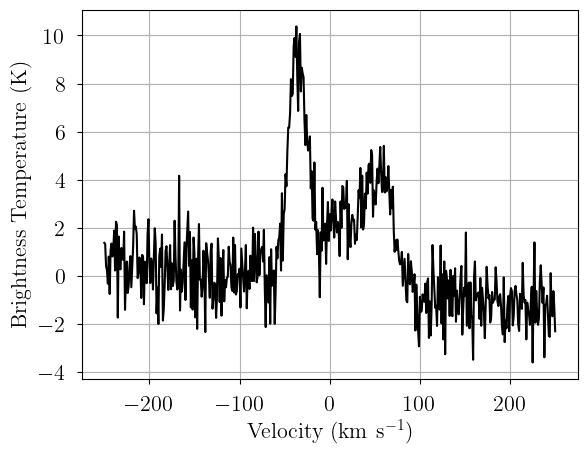

In [2]:
from bayes_spec import SpecData
from bayes_spec.models import GaussNoiseModel

# Generate dummy data format for simulation
velocity_axis = np.linspace(-250.0, 250.0, 501) # km/s
noise = 1.0 # K
brightness_data = noise * np.random.randn(len(velocity_axis)) # K

observation = SpecData(
    velocity_axis,
    brightness_data,
    noise,
    xlabel=r"Velocity (km s$^{-1}$)",
    ylabel="Brightness Temperature (K)",
)
dummy_data = {"observation": observation}

# Initialize and define the model
model = GaussNoiseModel(dummy_data, n_clouds=3, baseline_degree=2, seed=1234, verbose=True)
model.add_priors(
    prior_line_area = 500.0, # mode of k=2 gamma distribution prior on line area (K km s-1)
    prior_fwhm = 25.0, # mode of k=2 gamma distribution prior on FWHM line width (km s-1)
    prior_velocity = [0.0, 50.0], # mean and width of normal distribution prior on centroid velocity (km s-1)
    prior_baseline_coeffs = [1.0, 1.0, 1.0], # width of normal distribution prior on normalized baseline coefficients
    prior_rms = 1.0, # width of half-normal distribution prior on spectral rms (K)
)
model.add_likelihood()

# Simulate observation
sim_brightness = model.model.observation.eval({
    "fwhm": [25.0, 40.0, 35.0], # FWHM line width (km/s)
    "line_area": [250.0, 125.0, 175.0], # line area (K km/s)
    "velocity": [-35.0, 10.0, 55.0], # velocity (km/s)
    "observation_baseline_norm": [-0.5, -2.0, 3.0], # normalized baseline coefficients
    "rms_observation": noise, # spectral rms (K)
})

# Plot the simulated data
plt.plot(dummy_data["observation"].spectral, sim_brightness, 'k-')
plt.xlabel(dummy_data["observation"].xlabel)
plt.ylabel(dummy_data["observation"].ylabel)

In [3]:
# Pack simulated data into SpecData
observation = SpecData(
    velocity_axis,
    sim_brightness,
    noise,
    xlabel=r"Velocity (km s$^{-1}$)",
    ylabel="Brightness Temperature (K)",
)
data = {"observation": observation}

## `Optimize`

We use the `Optimize` class for optimization.

In [4]:
from bayes_spec import Optimize

# Initialize optimizer
opt = Optimize(
    GaussNoiseModel,  # model definition
    data,  # data dictionary
    max_n_clouds=5,  # maximum number of clouds
    baseline_degree=2,  # polynomial baseline degree
    seed=1234,  # random seed
    verbose=True,  # verbosity
)

# Define each model
opt.add_priors(
    prior_line_area = 200.0, # mode of k=2 gamma distribution prior on line area (K km s-1)
    prior_fwhm = 30.0, # mode of k=2 gamma distribution prior on FWHM line width (km s-1)
    prior_velocity = [0.0, 50.0], # mean and width of normal distribution prior on centroid velocity (km s-1)
    prior_baseline_coeffs = [1.0, 1.0, 1.0], # width of normal distribution prior on normalized baseline coefficients
    prior_rms = 2.0, # width of half-normal distribution prior on spectral rms (K)
)
opt.add_likelihood()

`Optimize` has created `max_n_clouds` models, where `opt.models[1]` has `n_clouds=1`, `opt.models[2]` has `n_clouds=2`, etc.

In [5]:
print(opt.models[4])
print(opt.models[4].n_clouds)

4


By default (`approx=True`), the optimization algorithm first loops over every model and approximates the posterior distribution using variational inference. We can supply arguments to `fit` and `sample` via dictionaries. Whichever model is the first to have a BIC within `bic_threshold` of the minimum BIC is the "best" model, and is then sampled with MCMC.

In [6]:
fit_kwargs = {
    "rel_tolerance": 0.01,
    "abs_tolerance": 0.1,
    "learning_rate": 1e-2,
}
sample_kwargs = {
    "chains": 4,
    "cores": 4,
    "init_kwargs": fit_kwargs,
    "nuts_kwargs": {"target_accept": 0.8},
}
opt.optimize(bic_threshold=10.0, sample_kwargs=sample_kwargs, fit_kwargs=fit_kwargs)

Null hypothesis BIC = 2.969e+03
Approximating n_cloud = 1 posterior...


Output()

Convergence achieved at 2300
Interrupted at 2,299 [2%]: Average Loss = 1,113.9


GMM converged to unique solution
n_cloud = 1 solution = 0 BIC = 1.986e+03

Approximating n_cloud = 2 posterior...


Output()

Convergence achieved at 2000
Interrupted at 1,999 [1%]: Average Loss = 1,204.9


No solution found!
GMM found 0 unique solutions

Approximating n_cloud = 3 posterior...


Output()

Convergence achieved at 1900
Interrupted at 1,899 [1%]: Average Loss = 1,458.4


No solution found!
GMM found 0 unique solutions

Approximating n_cloud = 4 posterior...


Output()

Convergence achieved at 2100
Interrupted at 2,099 [2%]: Average Loss = 1,511.6


No solution found!
GMM found 0 unique solutions

Approximating n_cloud = 5 posterior...


Output()

Convergence achieved at 2100
Interrupted at 2,099 [2%]: Average Loss = 1,449.8


No solution found!
GMM found 0 unique solutions

Sampling best model (n_cloud = 1)...
Initializing NUTS using custom advi+adapt_diag strategy


Output()

Convergence achieved at 2300
Interrupted at 2,299 [2%]: Average Loss = 1,113.9
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [observation_baseline_norm, line_area_norm, fwhm_norm, velocity_norm, rms_observation_norm]


Output()

Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 8 seconds.


GMM converged to unique solution


The "best" model is saved in `opt.best_model`.

In [7]:
print(f"Best model has n_clouds = {opt.best_model.n_clouds}")
az.summary(opt.best_model.trace.solution_0)

Best model has n_clouds = 1


,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
amplitude[0],4.768,0.261,4.267,5.239,0.005,0.004,2662.0,3305.0,1.0
fwhm[0],129.415,6.739,117.197,142.186,0.146,0.103,2156.0,2476.0,1.0
fwhm_norm[0],4.314,0.225,3.907,4.740,0.005,0.003,2156.0,2476.0,1.0
line_area[0],656.932,50.675,562.668,752.353,1.313,0.932,1497.0,2056.0,1.0
line_area_norm[0],3.285,0.253,2.813,3.762,0.007,0.005,1497.0,2056.0,1.0
observation_baseline_norm[0],-0.585,0.076,-0.726,-0.444,0.002,0.001,1441.0,1916.0,1.0
observation_baseline_norm[1],-0.793,0.117,-1.009,-0.570,0.002,0.002,2801.0,2142.0,1.0
observation_baseline_norm[2],0.859,0.867,-0.779,2.425,0.021,0.015,1756.0,2568.0,1.0
rms_observation,1.666,0.054,1.569,1.769,0.001,0.001,3836.0,2927.0,1.0
rms_observation_norm,0.833,0.027,0.784,0.885,0.000,0.000,3836.0,2927.0,1.0


With `approx=False`, the optimization algorithm samples each model with MCMC (or SMC if `smc=True`) and determines which is the first model with a BIC within `bic_threshold` of the minimum across all models. This is more accurate, but slower. Be careful not to set `max_n_clouds` too high!

In [8]:
opt.optimize(sample_kwargs=sample_kwargs, approx=False)

Null hypothesis BIC = 2.969e+03
Sampling n_cloud = 1 posterior...
Initializing NUTS using custom advi+adapt_diag strategy


Output()

Convergence achieved at 2300
Interrupted at 2,299 [2%]: Average Loss = 1,113.9
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [observation_baseline_norm, line_area_norm, fwhm_norm, velocity_norm, rms_observation_norm]


Output()

Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 20 seconds.


GMM converged to unique solution
n_cloud = 1 solution = 0 BIC = 1.985e+03

Sampling n_cloud = 2 posterior...
Initializing NUTS using custom advi+adapt_diag strategy


Output()

Convergence achieved at 2000
Interrupted at 1,999 [1%]: Average Loss = 1,204.9
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [observation_baseline_norm, line_area_norm, fwhm_norm, velocity_norm, rms_observation_norm]


Output()

Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 10 seconds.


GMM converged to unique solution
Label order mismatch in solution 0
Chain 0 order: [1 0]
Chain 1 order: [1 0]
Chain 2 order: [0 1]
Chain 3 order: [1 0]
Adopting (first) most common order: [1 0]
n_cloud = 2 solution = 0 BIC = 1.559e+03

Sampling n_cloud = 3 posterior...
Initializing NUTS using custom advi+adapt_diag strategy


Output()

Convergence achieved at 1900
Interrupted at 1,899 [1%]: Average Loss = 1,458.4
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [observation_baseline_norm, line_area_norm, fwhm_norm, velocity_norm, rms_observation_norm]


Output()

Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 45 seconds.


GMM converged to unique solution
Label order mismatch in solution 0
Chain 0 order: [1 2 0]
Chain 1 order: [2 1 0]
Chain 2 order: [1 2 0]
Chain 3 order: [2 1 0]
Adopting (first) most common order: [1 2 0]
n_cloud = 3 solution = 0 BIC = 1.521e+03

Sampling n_cloud = 4 posterior...
Initializing NUTS using custom advi+adapt_diag strategy


Output()

Convergence achieved at 2100
Interrupted at 2,099 [2%]: Average Loss = 1,511.6
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [observation_baseline_norm, line_area_norm, fwhm_norm, velocity_norm, rms_observation_norm]


Output()

Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 99 seconds.


There were 10 divergences in converged chains.
No solution found!
GMM found 0 unique solutions

Sampling n_cloud = 5 posterior...
Initializing NUTS using custom advi+adapt_diag strategy


Output()

Convergence achieved at 2100
Interrupted at 2,099 [2%]: Average Loss = 1,449.8
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [observation_baseline_norm, line_area_norm, fwhm_norm, velocity_norm, rms_observation_norm]


Output()

Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 104 seconds.


No solution found!
GMM found 0 unique solutions



Notice that models with more complexity than is present in the data (i.e., `n_clouds` > the true number of clouds) tend to have more divergences and difficulty converging.

In [9]:
print(f"Best model has n_clouds = {opt.best_model.n_clouds}")
az.summary(opt.best_model.trace.solution_0)

Best model has n_clouds = 3


,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
amplitude[0],9.216,0.388,8.480,9.950,0.008,0.006,2230.0,2771.0,1.0
amplitude[1],4.327,0.549,3.333,5.336,0.016,0.011,1212.0,2570.0,1.0
amplitude[2],2.841,0.244,2.337,3.258,0.004,0.003,2985.0,3049.0,1.0
fwhm[0],23.583,1.117,21.426,25.604,0.026,0.018,1914.0,2094.0,1.0
fwhm[1],34.372,3.497,27.752,40.792,0.092,0.065,1440.0,2260.0,1.0
fwhm[2],58.992,13.538,34.927,84.114,0.414,0.293,1091.0,2008.0,1.0
fwhm_norm[0],0.786,0.037,0.714,0.853,0.001,0.001,1914.0,2094.0,1.0
fwhm_norm[1],1.146,0.117,0.925,1.360,0.003,0.002,1440.0,2260.0,1.0
fwhm_norm[2],1.966,0.451,1.164,2.804,0.014,0.010,1091.0,2008.0,1.0
line_area[0],231.418,15.537,200.830,258.435,0.421,0.297,1392.0,1790.0,1.0


With posteriors sampled with MCMC, we can also use leave-one-out cross-validation to perform model comparison.

In [10]:
# Populate models with likelihood samples
for model in opt.models.values():
    with model.model:
        pm.compute_log_likelihood(model.trace)

Output()

Output()

Output()

Output()

Output()

In [11]:
# leave-one-out cross validation
loo = az.compare({
    n_gauss: model.trace for n_gauss, model in opt.models.items()
    if model.solutions # ignore models with no valid solutions
})
loo

,rank,elpd_loo,p_loo,elpd_diff,weight,se,dse,warning,scale
3,0,-717.234006,10.293709,0.000000,1.000000e+00,16.688612,0.000000,False,log
2,1,-747.884781,9.408064,30.650775,0.000000e+00,15.815886,6.761395,False,log
1,2,-970.389533,8.158134,253.155527,1.289957e-09,23.957734,25.620799,False,log


The model with the largest `elpd_loo` is preferred.

Sampling: [observation]


Output()

array([[<Axes: xlabel='Velocity (km s$^{-1}$)', ylabel='Brightness Temperature (K)'>]],
      dtype=object)

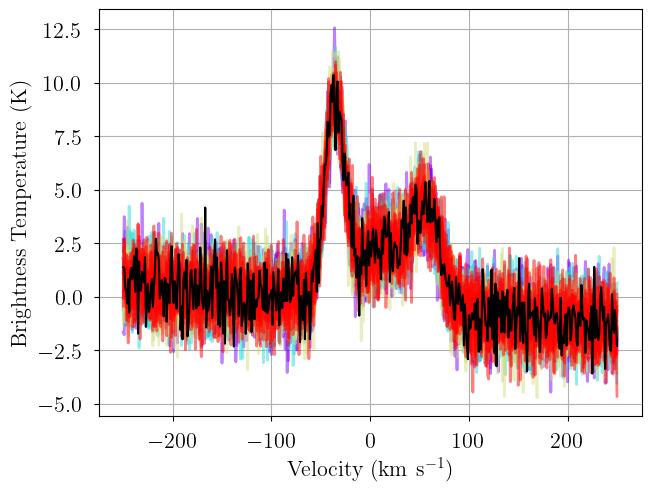

In [12]:
from bayes_spec.plots import plot_predictive

posterior = model.sample_posterior_predictive(
    thin=100, # keep one in {thin} posterior samples
)
plot_predictive(model.data, posterior.posterior_predictive)